# Big Project
## Group 10 - Data Under Construction

### Setup Notebook

In [1]:
!pip install geopandas

In [2]:
# Import 3rd party libraries
import os
import json
import requests
import numpy as np
import pandas as pd
import seaborn as sns
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
import matplotlib.patches as mpatches

# Configure Notebook
%matplotlib inline 
plt.style.use('seaborn-v0_8-ticks')
sns.set_context("notebook")
import warnings
warnings.filterwarnings('ignore')

In [3]:
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [4]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, TimeSeriesSplit
from sklearn.base import clone

In [5]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import cross_val_score, cross_validate

In [6]:
from sklearn.inspection import permutation_importance

### 1. Collecting and Cleaning Data 

#### 1.1 Neighbourhoods Data

First, we need the Toronto Neighborhoods geodata to locate the different listings in their specific neighborhoods. To do so, we will use the Boundaries of Toronto Neighbourhoods files from Toronto Open Data.

In [7]:
# Load the shapefile (use the path to the .shp file)
neighbourhoods = gpd.read_file('Neighbourhoods - 4326.shp')

In [8]:
# Display the first few rows of the neighbourhoods GeoDataFrame
neighbourhoods.head()

,_id1,AREA_ID2,AREA_AT3,PARENT_4,AREA_SH5,AREA_LO6,AREA_NA7,AREA_DE8,CLASSIF9,CLASSIF10,OBJECTI11,geometry
0,1,2502366,26022881,0,174,174,South Eglinton-Davisville,South Eglinton-Davisville (174),Not an NIA or Emerging Neighbourhood,NA,17824737.0,"POLYGON ((-79.38635 43.69783, -79.38623 43.697..."
1,2,2502365,26022880,0,173,173,North Toronto,North Toronto (173),Not an NIA or Emerging Neighbourhood,NA,17824753.0,"POLYGON ((-79.39744 43.70693, -79.39837 43.706..."
2,3,2502364,26022879,0,172,172,Dovercourt Village,Dovercourt Village (172),Not an NIA or Emerging Neighbourhood,NA,17824769.0,"POLYGON ((-79.43411 43.66015, -79.43537 43.659..."
3,4,2502363,26022878,0,171,171,Junction-Wallace Emerson,Junction-Wallace Emerson (171),Not an NIA or Emerging Neighbourhood,NA,17824785.0,"POLYGON ((-79.43870 43.66766, -79.43841 43.666..."
4,5,2502362,26022877,0,170,170,Yonge-Bay Corridor,Yonge-Bay Corridor (170),Not an NIA or Emerging Neighbourhood,NA,17824801.0,"POLYGON ((-79.38404 43.64497, -79.38502 43.644..."


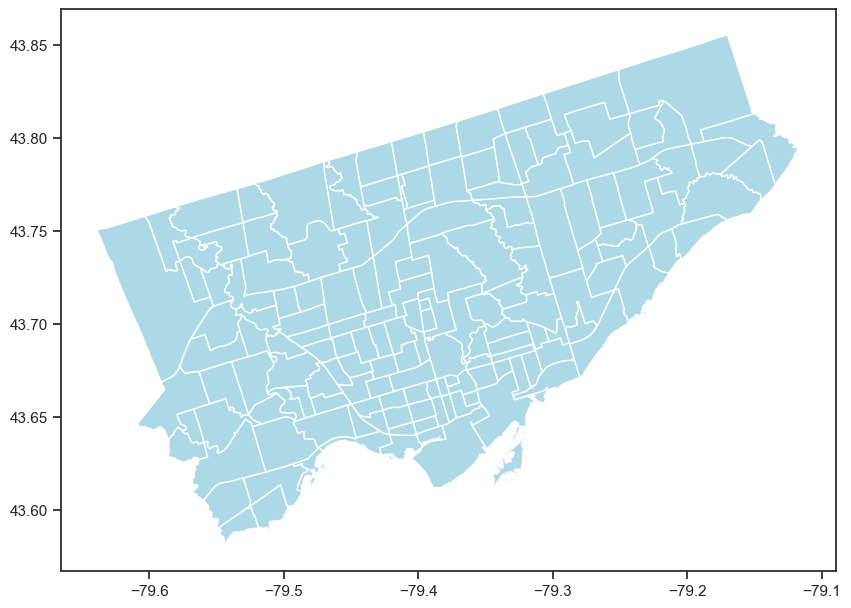

In [9]:
# Plot the neighborhoods
fig, ax = plt.subplots(figsize=(10, 10))
neighbourhoods.plot(ax=ax, color='lightblue', edgecolor='white')
plt.show()

Next, we will create a dictionary for the ranking of neighborhoods. This ranking is from the Toronto Life website, and it is based on 10 different factors including Safety, Community, Transit, ...etc.

In [10]:
# Define the neighborhood ranking as a dictionary
neighbourhood_ranking = {
    'Danforth': 1,
    'West Queen West': 2,
    'Runnymede-Bloor West Village': 3,
    'Avondale': 4,
    'Wellington Place': 5,
    'Yonge-Doris': 6,
    'Cabbagetown-South St.James Town': 7,
    'Bay-Cloverhill': 8,
    'Palmerston-Little Italy': 9,
    'Trinity-Bellwoods': 10,
    'Bridle Path-Sunnybrook-York Mills': 11,
    'Annex': 12,
    'North Riverdale': 13,
    'Mount Pleasant East': 14,
    'Lawrence Park North': 15,
    'Kingsway South': 16,
    'University': 17,
    'Yonge-Bay Corridor': 18,
    'Leaside-Bennington': 19,
    'South Eglinton-Davisville': 20,
    'Harbourfront-CityPlace': 21,
    'Wychwood': 22,
    'Dovercourt Village': 23,
    'Blake-Jones': 24,
    'Roncesvalles': 25,
    'Dufferin Grove': 26,
    'Lawrence Park South': 27,
    'Church-Wellesley': 28,
    'Casa Loma': 29,
    'Woodbine-Lumsden': 30,
    'Danforth East York': 31,
    'Regent Park': 32,
    'Lansing-Westgate': 33,
    'Downtown Yonge East': 34,
    'St Lawrence-East Bayfront-The Islands': 35,
    'Yonge-Eglinton': 36,
    'High Park-Swansea': 37,
    'Little Portugal': 38,
    'Forest Hill South': 39,
    'Playter Estates-Danforth': 40,
    'Junction Area': 41,
    'Woodbine Corridor': 42,
    'The Beaches': 43,
    'Rosedale-Moore Park': 44,
    'Old East York': 45,
    'Bedford Park-Nortown': 46,
    'High Park North': 47,
    'Kensington-Chinatown': 48,
    'Yonge-St.Clair': 49,
    'Junction-Wallace Emerson': 50,
    'Princess-Rosethorn': 51,
    'Fort York-Liberty Village': 52,
    'North St.James Town': 53,
    'Willowdale West': 54,
    'North Toronto': 55,
    'Greenwood-Coxwell': 56,
    'Bayview Village': 57,
    'South Riverdale': 58,
    'Humewood-Cedarvale': 59,
    'East End-Danforth': 60,
    'Taylor-Massey': 61,
    'East Willowdale': 62,
    'Corso Italia-Davenport': 63,
    'Etobicoke City Centre': 64,
    'Stonegate-Queensway': 65,
    'Centennial Scarborough': 66,
    'Hillcrest Village': 67,
    'Humber Bay Shores': 68,
    'Moss Park': 69,
    'Broadview North': 70,
    'Morningside Heights': 71,
    'Lambton Baby Point': 72,
    'Newtonbrook East': 73,
    'Malvern West': 74,
    'Forest Hill North': 75,
    'Clanton Park': 76,
    'Pleasant View': 77,
    'Banbury-Don Mills': 78,
    'Malvern East': 79,
    'Islington': 80,
    'Markland Wood': 81,
    'Highland Creek': 82,
    'Agincourt North': 83,
    'Edenbridge-Humber Valley': 84,
    'East L\'Amoreaux': 85,
    'Alderwood': 86,
    'Milliken': 87,
    'Henry Farm': 88,
    'Steeles': 89,
    'St.Andrew-Windfields': 90,
    'Pelmo Park-Humberlea': 91,
    'Guildwood': 92,
    'Oakwood Village': 93,
    'Agincourt South-Malvern West': 94,
    'Birchcliffe-Cliffside': 95,
    'Clairlea-Birchmount': 96,
    'Englemount-Lawrence': 97,
    'West Rouge': 98,
    'Tam O\'Shanter-Sullivan': 99,
    'Briar Hill-Belgravia': 100,
    'Bayview Woods-Steeles': 101,
    'Weston-Pelham Park': 102,
    'Bathurst Manor': 103,
    'Woburn North': 104,
    'Bendale South': 105,
    'Newtonbrook West': 106,
    'L\'Amoreaux West': 107,
    'Eringate-Centennial-West Deane': 108,
    'Flemingdon Park': 109,
    'Westminster-Branson': 110,
    'Don Valley Village': 111,
    'Long Branch': 112,
    'Caledonia-Fairbank': 113,
    'Humber Heights-Westmount': 114,
    'Parkwoods-O\'Connor Hills': 115,
    'Rockcliffe-Smythe': 116,
    'Thistletown-Beaumond Heights': 117,
    'Keelesdale-Eglinton West': 118,
    'Maple Leaf': 119,
    'O\'Connor-Parkview': 120,
    'Etobicoke West Mall': 121,
    'Morningside': 122,
    'Mimico-Queensway': 123,
    'Bendale-Glen Andrew': 124,
    'Oakridge': 125,
    'Dorset Park': 126,
    'Thorncliffe Park': 127,
    'Wexford/Maryvale': 128,
    'Victoria Village': 129,
    'Elms-Old Rexdale': 130,
    'Cliffcrest': 131,
    'Humbermede': 132,
    'Mount Dennis': 133,
    'Ionview': 134,
    'Willowridge-Martingrove-Richview': 135,
    'Downsview': 136,
    'Kingsview Village-The Westway': 137,
    'Eglinton East': 138,
    'Fenside-Parkwoods': 139,
    'Yorkdale-Glen Park': 140,
    'Mount Olive-Silverstone-Jamestown': 141,
    'West Humber-Clairville': 142,
    'Glenfield-Jane Heights': 143,
    'South Parkdale': 144,
    'York University Heights': 145,
    'New Toronto': 146,
    'Golfdale-Cedarbrae-Woburn': 147,
    'Brookhaven-Amesbury': 148,
    'Rexdale-Kipling': 149,
    'Rustic': 150,
    'Humber Summit': 151,
    'Scarborough Village': 152,
    'Beechborough-Greenbrook': 153,
    'Oakdale-Beverley Heights': 154,
    'Weston': 155,
    'West Hill': 156,
    'Black Creek': 157,
    'Kennedy Park': 158
}

#### 1.2 Zillow Rent Data

Zillow website offers many csv files for rental listings. Five files were imported as shown below.

In [11]:
# Load each CSV file
zillow_one = pd.read_csv('zillow-one.csv')
zillow_two = pd.read_csv('zillow-two.csv')
zillow_three = pd.read_csv('zillow-three.csv')

In [12]:
zillow_one.head()

,Property URL,Property type,Number of days on Zillow,Date listed (MM/DD/YYYY),Rental price (USD per month),Living area,Living area unit,Price per living area unit (USD),Bedrooms,Bathrooms,...,Property unit number,Street address,City,Zip,Latitude,Longitude,Zillow property ID,Property is a building,Building name,Unit availability count
0,https://www.zillow.com/homedetails/413-Markham...,Apartment,2.0,11/04/2024,2400.0,900.0,sqft,2.67,1.0,1.0,...,NaN,413 Markham St,Toronto,NaN,43.660350,-79.410310,2063459583,NaN,NaN,NaN
1,https://www.zillow.com/homedetails/1221-King-S...,Apartment,2.0,11/04/2024,2200.0,500.0,sqft,4.40,1.0,1.0,...,# 7026,1221 King St W,Toronto,NaN,43.638584,-79.427666,2054131263,NaN,NaN,NaN
2,https://www.zillow.com/homedetails/47-Lower-Ri...,Apartment,2.0,11/04/2024,2200.0,500.0,sqft,4.40,1.0,1.0,...,NaN,47 Lower River St,Toronto,NaN,43.656498,-79.355540,2079696219,NaN,NaN,NaN
3,https://www.zillow.com/b/1350-ellesmere-rd-tor...,Building,3.0,11/03/2024,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1350 Ellesmere Rd,Toronto,NaN,43.770374,-79.261860,43.770374--79.26186,Yes,Red-Three Building (Randomly generated buildin...,3.0
4,https://www.zillow.com/b/1350-ellesmere-rd-tor...,Apartment,NaN,NaN,2200.0,NaN,NaN,NaN,1.0,NaN,...,NaN,1350 Ellesmere Rd,Toronto,NaN,NaN,NaN,NaN,No,Unit located in: Red-Three Building,NaN


In [13]:
zillow_one.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1188 entries, 0 to 1187
Data columns (total 23 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Property URL                      1188 non-null   object 
 1   Property type                     1188 non-null   object 
 2   Number of days on Zillow          736 non-null    float64
 3   Date listed (MM/DD/YYYY)          736 non-null    object 
 4   Rental price (USD per month)      819 non-null    float64
 5   Living area                       95 non-null     float64
 6   Living area unit                  95 non-null     object 
 7   Price per living area unit (USD)  95 non-null     float64
 8   Bedrooms                          819 non-null    float64
 9   Bathrooms                         450 non-null    float64
 10  Image URL                         811 non-null    object 
 11  Is owner occupied                 450 non-null    object 
 12  Proper

In [14]:
def filter_zillow(df):
    # Filter the DataFrame to keep only rows with non-null values in the "Living area" column and "latitude" column
    Zillow_filtered = df[df['Living area'].notnull()]
    Zillow_filtered = Zillow_filtered.dropna(subset=['Latitude'])

    # Select only specific columns (Note that the rental price is in CAD but Zillow mistakenly write it in USD)
    Zillow_filtered = Zillow_filtered[['Rental price (USD per month)', 'Living area', 
                            'Bedrooms', 'Bathrooms', 'Street address', 'Latitude', 'Longitude','Zillow property ID']]

    # Rename specific columns
    Zillow_filtered = Zillow_filtered.rename(columns={'Rental price (USD per month)': 'Rent Price (CAD)',
                                                            'Living area': 'Living Area (sqft)',
                                                            'Street address': 'Address',
                                                            'Zillow property ID': 'Listing ID'})

    # Perform a spatial join to add the neighborhood name (from AREA_NA7) to each apartment
    geometry = [Point(xy) for xy in zip(Zillow_filtered['Longitude'], Zillow_filtered['Latitude'])]
    Zillow_filtered = gpd.GeoDataFrame(Zillow_filtered, geometry=geometry, crs='EPSG:4326')
    Zillow_hood = gpd.sjoin(Zillow_filtered, neighbourhoods, how="left", predicate="within")

    # Assign the neighborhood name from AREA_NA7 to a new column in the filtered DataFrame
    Zillow_filtered['Neighbourhood'] = Zillow_hood['AREA_NA7']

    # Map the ranks to the 'Neighbourhood' column in filtered_gdf
    Zillow_filtered['Neighbourhood Rank'] = Zillow_filtered['Neighbourhood'].map(neighbourhood_ranking)

    # Add 'Source' column
    Zillow_filtered['Source'] = 'Zillow'

    # Rearrange columns
    Zillow_filtered = Zillow_filtered[['Listing ID',
                                       'Source',
                                       'Address',
                                       'Bedrooms',
                                       'Bathrooms',
                                       'Living Area (sqft)',
                                       'Latitude',
                                       'Longitude',
                                       'Neighbourhood',
                                       'Neighbourhood Rank',
                                       'Rent Price (CAD)']]

    Zillow_filtered = Zillow_filtered.reset_index(drop=True)
    
    return Zillow_filtered

In [15]:
Zillow_one_filtered = filter_zillow(zillow_one)
Zillow_two_filtered = filter_zillow(zillow_two)
Zillow_three_filtered = filter_zillow(zillow_three)

In [16]:
# Display the filtered DataFrame info to verify
Zillow_one_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91 entries, 0 to 90
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Listing ID          91 non-null     object 
 1   Source              91 non-null     object 
 2   Address             91 non-null     object 
 3   Bedrooms            91 non-null     float64
 4   Bathrooms           91 non-null     float64
 5   Living Area (sqft)  91 non-null     float64
 6   Latitude            91 non-null     float64
 7   Longitude           91 non-null     float64
 8   Neighbourhood       91 non-null     object 
 9   Neighbourhood Rank  91 non-null     int64  
 10  Rent Price (CAD)    91 non-null     float64
dtypes: float64(6), int64(1), object(4)
memory usage: 7.9+ KB


In [17]:
# Display the filtered DataFrame info to verify
Zillow_two_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52 entries, 0 to 51
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Listing ID          52 non-null     object 
 1   Source              52 non-null     object 
 2   Address             52 non-null     object 
 3   Bedrooms            52 non-null     float64
 4   Bathrooms           52 non-null     float64
 5   Living Area (sqft)  52 non-null     float64
 6   Latitude            52 non-null     float64
 7   Longitude           52 non-null     float64
 8   Neighbourhood       52 non-null     object 
 9   Neighbourhood Rank  52 non-null     int64  
 10  Rent Price (CAD)    52 non-null     float64
dtypes: float64(6), int64(1), object(4)
memory usage: 4.6+ KB


In [18]:
# Display the filtered DataFrame info to verify
Zillow_three_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89 entries, 0 to 88
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Listing ID          89 non-null     object 
 1   Source              89 non-null     object 
 2   Address             89 non-null     object 
 3   Bedrooms            89 non-null     float64
 4   Bathrooms           89 non-null     float64
 5   Living Area (sqft)  89 non-null     float64
 6   Latitude            89 non-null     float64
 7   Longitude           89 non-null     float64
 8   Neighbourhood       89 non-null     object 
 9   Neighbourhood Rank  89 non-null     int64  
 10  Rent Price (CAD)    89 non-null     float64
dtypes: float64(6), int64(1), object(4)
memory usage: 7.8+ KB


#### 1.3 TRREB Rent Data

Refer to the TRREB notebook for the process of collecting the TRREB Rent Data.

In [19]:
trreb = pd.read_csv('TRREB_data_final.csv')

In [20]:
trreb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3356 entries, 0 to 3355
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   address             3356 non-null   object 
 1   beds                3356 non-null   object 
 2   baths               3356 non-null   int64  
 3   type                3356 non-null   object 
 4   price               3356 non-null   int64  
 5   sqft                3356 non-null   object 
 6   listing#            3356 non-null   object 
 7   sqft_min            3356 non-null   int64  
 8   sqft_max            3356 non-null   int64  
 9   sqft_avg            3356 non-null   float64
 10  Type                3356 non-null   object 
 11  Style               3356 non-null   object 
 12  LAT                 3355 non-null   float64
 13  LONG                3355 non-null   float64
 14  Neighbourhood       3355 non-null   object 
 15  Neighbourhood Rank  3355 non-null   float64
dtypes: flo

In [21]:
# Select only specific columns
trreb_filtered = trreb[['price', 'sqft_avg', 'beds', 'baths', 'address',
                        'LAT', 'LONG','listing#', 'Neighbourhood','Neighbourhood Rank']]

# Rename specific columns
trreb_filtered = trreb_filtered.rename(columns={'price': 'Rent Price (CAD)',
                                                'sqft_avg': 'Living Area (sqft)',
                                                'address': 'Address',
                                                'listing#': 'Listing ID',
                                                'LAT': 'Latitude',
                                                'LONG': 'Longitude',
                                                'beds': 'Bedrooms',
                                                'baths': 'Bathrooms'})

# Add 'Source' column
trreb_filtered['Source'] = 'TRREB'

# Rearrange columns
trreb_filtered = trreb_filtered[['Listing ID',
                                 'Source',
                                 'Address',
                                 'Bedrooms',
                                 'Bathrooms',
                                 'Living Area (sqft)',
                                 'Latitude',
                                 'Longitude',
                                 'Neighbourhood',
                                 'Neighbourhood Rank',
                                 'Rent Price (CAD)']]

trreb_filtered = trreb_filtered.dropna()

trreb_filtered = trreb_filtered.reset_index(drop=True)

In [22]:
# Display the filtered DataFrame info to verify
trreb_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3355 entries, 0 to 3354
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Listing ID          3355 non-null   object 
 1   Source              3355 non-null   object 
 2   Address             3355 non-null   object 
 3   Bedrooms            3355 non-null   object 
 4   Bathrooms           3355 non-null   int64  
 5   Living Area (sqft)  3355 non-null   float64
 6   Latitude            3355 non-null   float64
 7   Longitude           3355 non-null   float64
 8   Neighbourhood       3355 non-null   object 
 9   Neighbourhood Rank  3355 non-null   float64
 10  Rent Price (CAD)    3355 non-null   int64  
dtypes: float64(4), int64(2), object(5)
memory usage: 288.4+ KB


#### 1.4 Rentals.ca Data

Refer to the Rentals.ca notebook for the process of collecting the TRREB Rent Data.

In [23]:
rentals = pd.read_csv('rentals_data_final.csv')

In [24]:
rentals.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 759 entries, 0 to 758
Data columns (total 14 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Listing price                    759 non-null    float64
 1   Verified                         308 non-null    object 
 2   Updated                          169 non-null    object 
 3   Bed                              759 non-null    float64
 4   Bathroom                         759 non-null    float64
 5   sqft                             759 non-null    object 
 6   address                          759 non-null    object 
 7   listing-card__details-link href  759 non-null    object 
 8   City/Zone                        759 non-null    object 
 9   LAT                              759 non-null    float64
 10  LONG                             759 non-null    float64
 11  geometry                         759 non-null    object 
 12  Neighbourhood         

In [25]:
# Select only specific columns
rentals_filtered = rentals[['Listing price', 'Bed', 'Bathroom', 'sqft', 'address',
                        'LAT', 'LONG','listing-card__details-link href', 'Neighbourhood','Neighbourhood Rank']]

# Rename specific columns
rentals_filtered = rentals_filtered.rename(columns={'Listing price': 'Rent Price (CAD)',
                                                'sqft': 'Living Area (sqft)',
                                                'address': 'Address',
                                                'listing-card__details-link href': 'Listing ID',
                                                'LAT': 'Latitude',
                                                'LONG': 'Longitude',
                                                'Bed': 'Bedrooms',
                                                'Bathroom': 'Bathrooms'})

# Add 'Source' column
rentals_filtered['Source'] = 'Rentals.ca'

# Rearrange columns
rentals_filtered = rentals_filtered[['Listing ID',
                                     'Source',
                                     'Address',
                                     'Bedrooms',
                                     'Bathrooms',
                                     'Living Area (sqft)',
                                     'Latitude',
                                     'Longitude',
                                     'Neighbourhood',
                                     'Neighbourhood Rank',
                                     'Rent Price (CAD)']]

rentals_filtered = rentals_filtered.dropna()

rentals_filtered = rentals_filtered.reset_index(drop=True)

In [26]:
# Display the filtered DataFrame info to verify
rentals_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 758 entries, 0 to 757
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Listing ID          758 non-null    object 
 1   Source              758 non-null    object 
 2   Address             758 non-null    object 
 3   Bedrooms            758 non-null    float64
 4   Bathrooms           758 non-null    float64
 5   Living Area (sqft)  758 non-null    object 
 6   Latitude            758 non-null    float64
 7   Longitude           758 non-null    float64
 8   Neighbourhood       758 non-null    object 
 9   Neighbourhood Rank  758 non-null    float64
 10  Rent Price (CAD)    758 non-null    float64
dtypes: float64(6), object(5)
memory usage: 65.3+ KB


In [27]:
# Convert Living area from string to numeric 
rentals_filtered['Living Area (sqft)'] = rentals_filtered['Living Area (sqft)'].apply(lambda x: float(x.split(' - ')[0]) if ' - ' in x else float(x))

In [28]:
# Check the vaules in the 'Bedroom' column
rentals_filtered['Bedrooms'].value_counts()

Bedrooms
1.0    264
2.0    216
1.5    176
2.5     39
3.0     27
0.0     21
0.5     11
3.5      2
4.0      1
7.0      1
Name: count, dtype: int64

In [29]:
# Drop all other than 1,1.5,2,2.5,3 bedrooms
rentals_filtered = rentals_filtered[rentals_filtered['Bedrooms'].isin([1, 1.5, 2, 2.5, 3])]

In [30]:
# Check the vaules in the 'Bedroom' column
rentals_filtered['Bedrooms'].value_counts()

Bedrooms
1.0    264
2.0    216
1.5    176
2.5     39
3.0     27
Name: count, dtype: int64

In [31]:
# Check the vaules in the 'Bathrooms' column
rentals_filtered['Bathrooms'].value_counts()

Bathrooms
1.0    429
2.0    244
1.5     19
2.5     11
3.0     10
0.5      4
0.0      4
4.0      1
Name: count, dtype: int64

In [32]:
rentals_filtered['Bathrooms'] = rentals_filtered['Bathrooms'].astype(float)

In [33]:
# Drop all other than 0.5,1,1.5,2,2.5,3 bathrooms
rentals_filtered = rentals_filtered[rentals_filtered['Bathrooms'].isin([1, 1.5, 2, 2.5, 3])]

In [34]:
# Check the vaules in the 'Bathrooms' column
rentals_filtered['Bathrooms'].value_counts()

Bathrooms
1.0    429
2.0    244
1.5     19
2.5     11
3.0     10
Name: count, dtype: int64

In [35]:
rentals_filtered = rentals_filtered.reset_index(drop=True)

In [36]:
rentals_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 713 entries, 0 to 712
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Listing ID          713 non-null    object 
 1   Source              713 non-null    object 
 2   Address             713 non-null    object 
 3   Bedrooms            713 non-null    float64
 4   Bathrooms           713 non-null    float64
 5   Living Area (sqft)  713 non-null    float64
 6   Latitude            713 non-null    float64
 7   Longitude           713 non-null    float64
 8   Neighbourhood       713 non-null    object 
 9   Neighbourhood Rank  713 non-null    float64
 10  Rent Price (CAD)    713 non-null    float64
dtypes: float64(7), object(4)
memory usage: 61.4+ KB


#### 1.5 Combined Data

In [37]:
# Combine into one dataframe
combined_data = pd.concat([Zillow_one_filtered, Zillow_two_filtered, Zillow_three_filtered,
                           trreb_filtered, rentals_filtered], ignore_index=True)

# Display the combined DataFrame info to verify
combined_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4300 entries, 0 to 4299
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Listing ID          4300 non-null   object 
 1   Source              4300 non-null   object 
 2   Address             4300 non-null   object 
 3   Bedrooms            4300 non-null   object 
 4   Bathrooms           4300 non-null   float64
 5   Living Area (sqft)  4300 non-null   float64
 6   Latitude            4300 non-null   float64
 7   Longitude           4300 non-null   float64
 8   Neighbourhood       4300 non-null   object 
 9   Neighbourhood Rank  4300 non-null   float64
 10  Rent Price (CAD)    4300 non-null   float64
dtypes: float64(6), object(5)
memory usage: 369.7+ KB


In [38]:
# Check the vaules in the 'Bedroom' column
combined_data['Bedrooms'].value_counts()

Bedrooms
1      1812
1+1    1518
1.0     354
2.0     266
1.5     171
3.0     115
2.5      39
1+0      19
1+2       6
Name: count, dtype: int64

In [39]:
# Convert string '1+0', '1', and '1.0' to numeric 1.0, leave others as is
combined_data['Bedrooms'] = combined_data['Bedrooms'].apply(lambda x: 1.0 if str(x) in ['1+0', '1', '1.0'] else x)

# Convert string '1+1' and '1+2' to numeric 1.5, leave others as is
combined_data['Bedrooms'] = combined_data['Bedrooms'].apply(lambda x: 1.5 if str(x) in ['1+1', '1+2'] else x)

In [40]:
# Check the conversion
combined_data['Bedrooms'].value_counts()

Bedrooms
1.0    2185
1.5    1695
2.0     266
3.0     115
2.5      39
Name: count, dtype: int64

In [41]:
# Check the vaules in the 'Bathrooms' column
combined_data['Bathrooms'].value_counts()

Bathrooms
1.0    3558
2.0     687
3.0      22
1.5      19
2.5      11
4.0       2
0.0       1
Name: count, dtype: int64

In [42]:
# Drop 0, 3 and 4 bathrooms in 1 bedroom listings
combined_data = combined_data[~((combined_data['Bathrooms'].isin([0, 3, 4])) & (combined_data['Bedrooms'].isin([1, 1.5])))]
# Drop 4 bathrooms in listings
combined_data = combined_data[~(combined_data['Bathrooms'].isin([4]))]

In [43]:
# Check
combined_data['Bathrooms'].value_counts()

Bathrooms
1.0    3558
2.0     687
3.0      19
1.5      19
2.5      11
Name: count, dtype: int64

In [44]:
# Drop duplicates based on 'Address'
combined_data = combined_data.drop_duplicates(subset='Address', keep='first')

In [45]:
# Reset index
combined_data= combined_data.reset_index(drop=True)

In [46]:
combined_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4071 entries, 0 to 4070
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Listing ID          4071 non-null   object 
 1   Source              4071 non-null   object 
 2   Address             4071 non-null   object 
 3   Bedrooms            4071 non-null   float64
 4   Bathrooms           4071 non-null   float64
 5   Living Area (sqft)  4071 non-null   float64
 6   Latitude            4071 non-null   float64
 7   Longitude           4071 non-null   float64
 8   Neighbourhood       4071 non-null   object 
 9   Neighbourhood Rank  4071 non-null   float64
 10  Rent Price (CAD)    4071 non-null   float64
dtypes: float64(7), object(4)
memory usage: 350.0+ KB


In [47]:
# Export the combined DataFrame to a CSV file
combined_data.to_csv('Final Data.csv', index=False)

print("Data exported successfully to 'Final Data.csv'")

Data exported successfully to 'Final Data.csv'


### 2. Exploratory Data Analysis

The data collection/cleaning section above created one single clean csv file, which will be used here.

In [48]:
df = pd.read_csv('Final Data.csv')

In [49]:
df.head()

,Listing ID,Source,Address,Bedrooms,Bathrooms,Living Area (sqft),Latitude,Longitude,Neighbourhood,Neighbourhood Rank,Rent Price (CAD)
0,2063459583,Zillow,413 Markham St,1.0,1.0,900.0,43.660350,-79.410310,Palmerston-Little Italy,9.0,2400.0
1,2054131263,Zillow,1221 King St W,1.0,1.0,500.0,43.638584,-79.427666,South Parkdale,144.0,2200.0
2,2079696219,Zillow,47 Lower River St,1.0,1.0,500.0,43.656498,-79.355540,Moss Park,69.0,2200.0
3,442326900,Zillow,120 Rowntree Mill Rd,1.0,1.0,800.0,43.753500,-79.577644,Humber Summit,151.0,1645.0
4,442260890,Zillow,1100 Sheppard Ave W,1.0,1.0,626.0,43.751930,-79.466700,York University Heights,145.0,2400.0


In [50]:
df.shape

(4071, 11)

Let's check for outliers based on the rent price and living area.

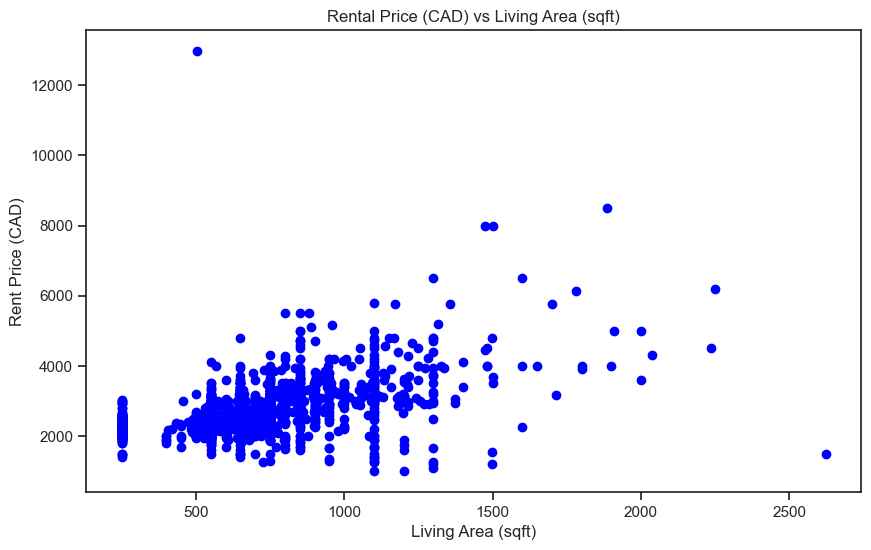

In [51]:
# Plot Rental price vs Living area
plt.figure(figsize=(10, 6))
plt.scatter(df['Living Area (sqft)'], df['Rent Price (CAD)'], color='blue')
plt.xlabel('Living Area (sqft)')
plt.ylabel('Rent Price (CAD)')
plt.title('Rental Price (CAD) vs Living Area (sqft)')
plt.show()

There seems to be some outliers. They will be checked individualy via going to their listings page and verifiying if it is correct. Also there seems to be only 7 different areas for the Toronto Realistate Board data this my be a problem.

In [52]:
# Filter for outliers: price above 10000 or area above 2500
outliers = df[(df['Rent Price (CAD)'] > 10000) | (df['Living Area (sqft)'] > 2500)]

# Display each outlier's information in a single row format
for index, row in outliers.iterrows():
    print(f"URL: {row['Address']}, Price: {row['Rent Price (CAD)']}, Area: {row['Living Area (sqft)']} sqft")

URL: 61 Yorkville Ave, Price: 12968.0, Area: 503.0 sqft
URL: 6A Leaside Park Dr Toronto, Price: 1500.0, Area: 2624.5 sqft


The 1500 CAD living area is misleading since it is the area of the full house, while a one-bedroom is rented only. So, it will be deleted.

The 12968 CAD seems to be mistake for that area. So, it will be deleted.

In [53]:
# Filter out the '6A Leaside Park Dr Toronto' listing
df = df[df['Living Area (sqft)'] <= 2500].reset_index(drop=True)

# Filter out the '61 Yorkville Ave' listing
df = df[df['Rent Price (CAD)'] <= 10000].reset_index(drop=True)

In [54]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4069 entries, 0 to 4068
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Listing ID          4069 non-null   object 
 1   Source              4069 non-null   object 
 2   Address             4069 non-null   object 
 3   Bedrooms            4069 non-null   float64
 4   Bathrooms           4069 non-null   float64
 5   Living Area (sqft)  4069 non-null   float64
 6   Latitude            4069 non-null   float64
 7   Longitude           4069 non-null   float64
 8   Neighbourhood       4069 non-null   object 
 9   Neighbourhood Rank  4069 non-null   float64
 10  Rent Price (CAD)    4069 non-null   float64
dtypes: float64(7), object(4)
memory usage: 349.8+ KB


In [55]:
# Update the CSV file
df.to_csv('Final Data.csv', index=False)

print("'Final Data.csv' has been updated successfully")

'Final Data.csv' has been updated successfully


#### 2.1 General Distribution Plots

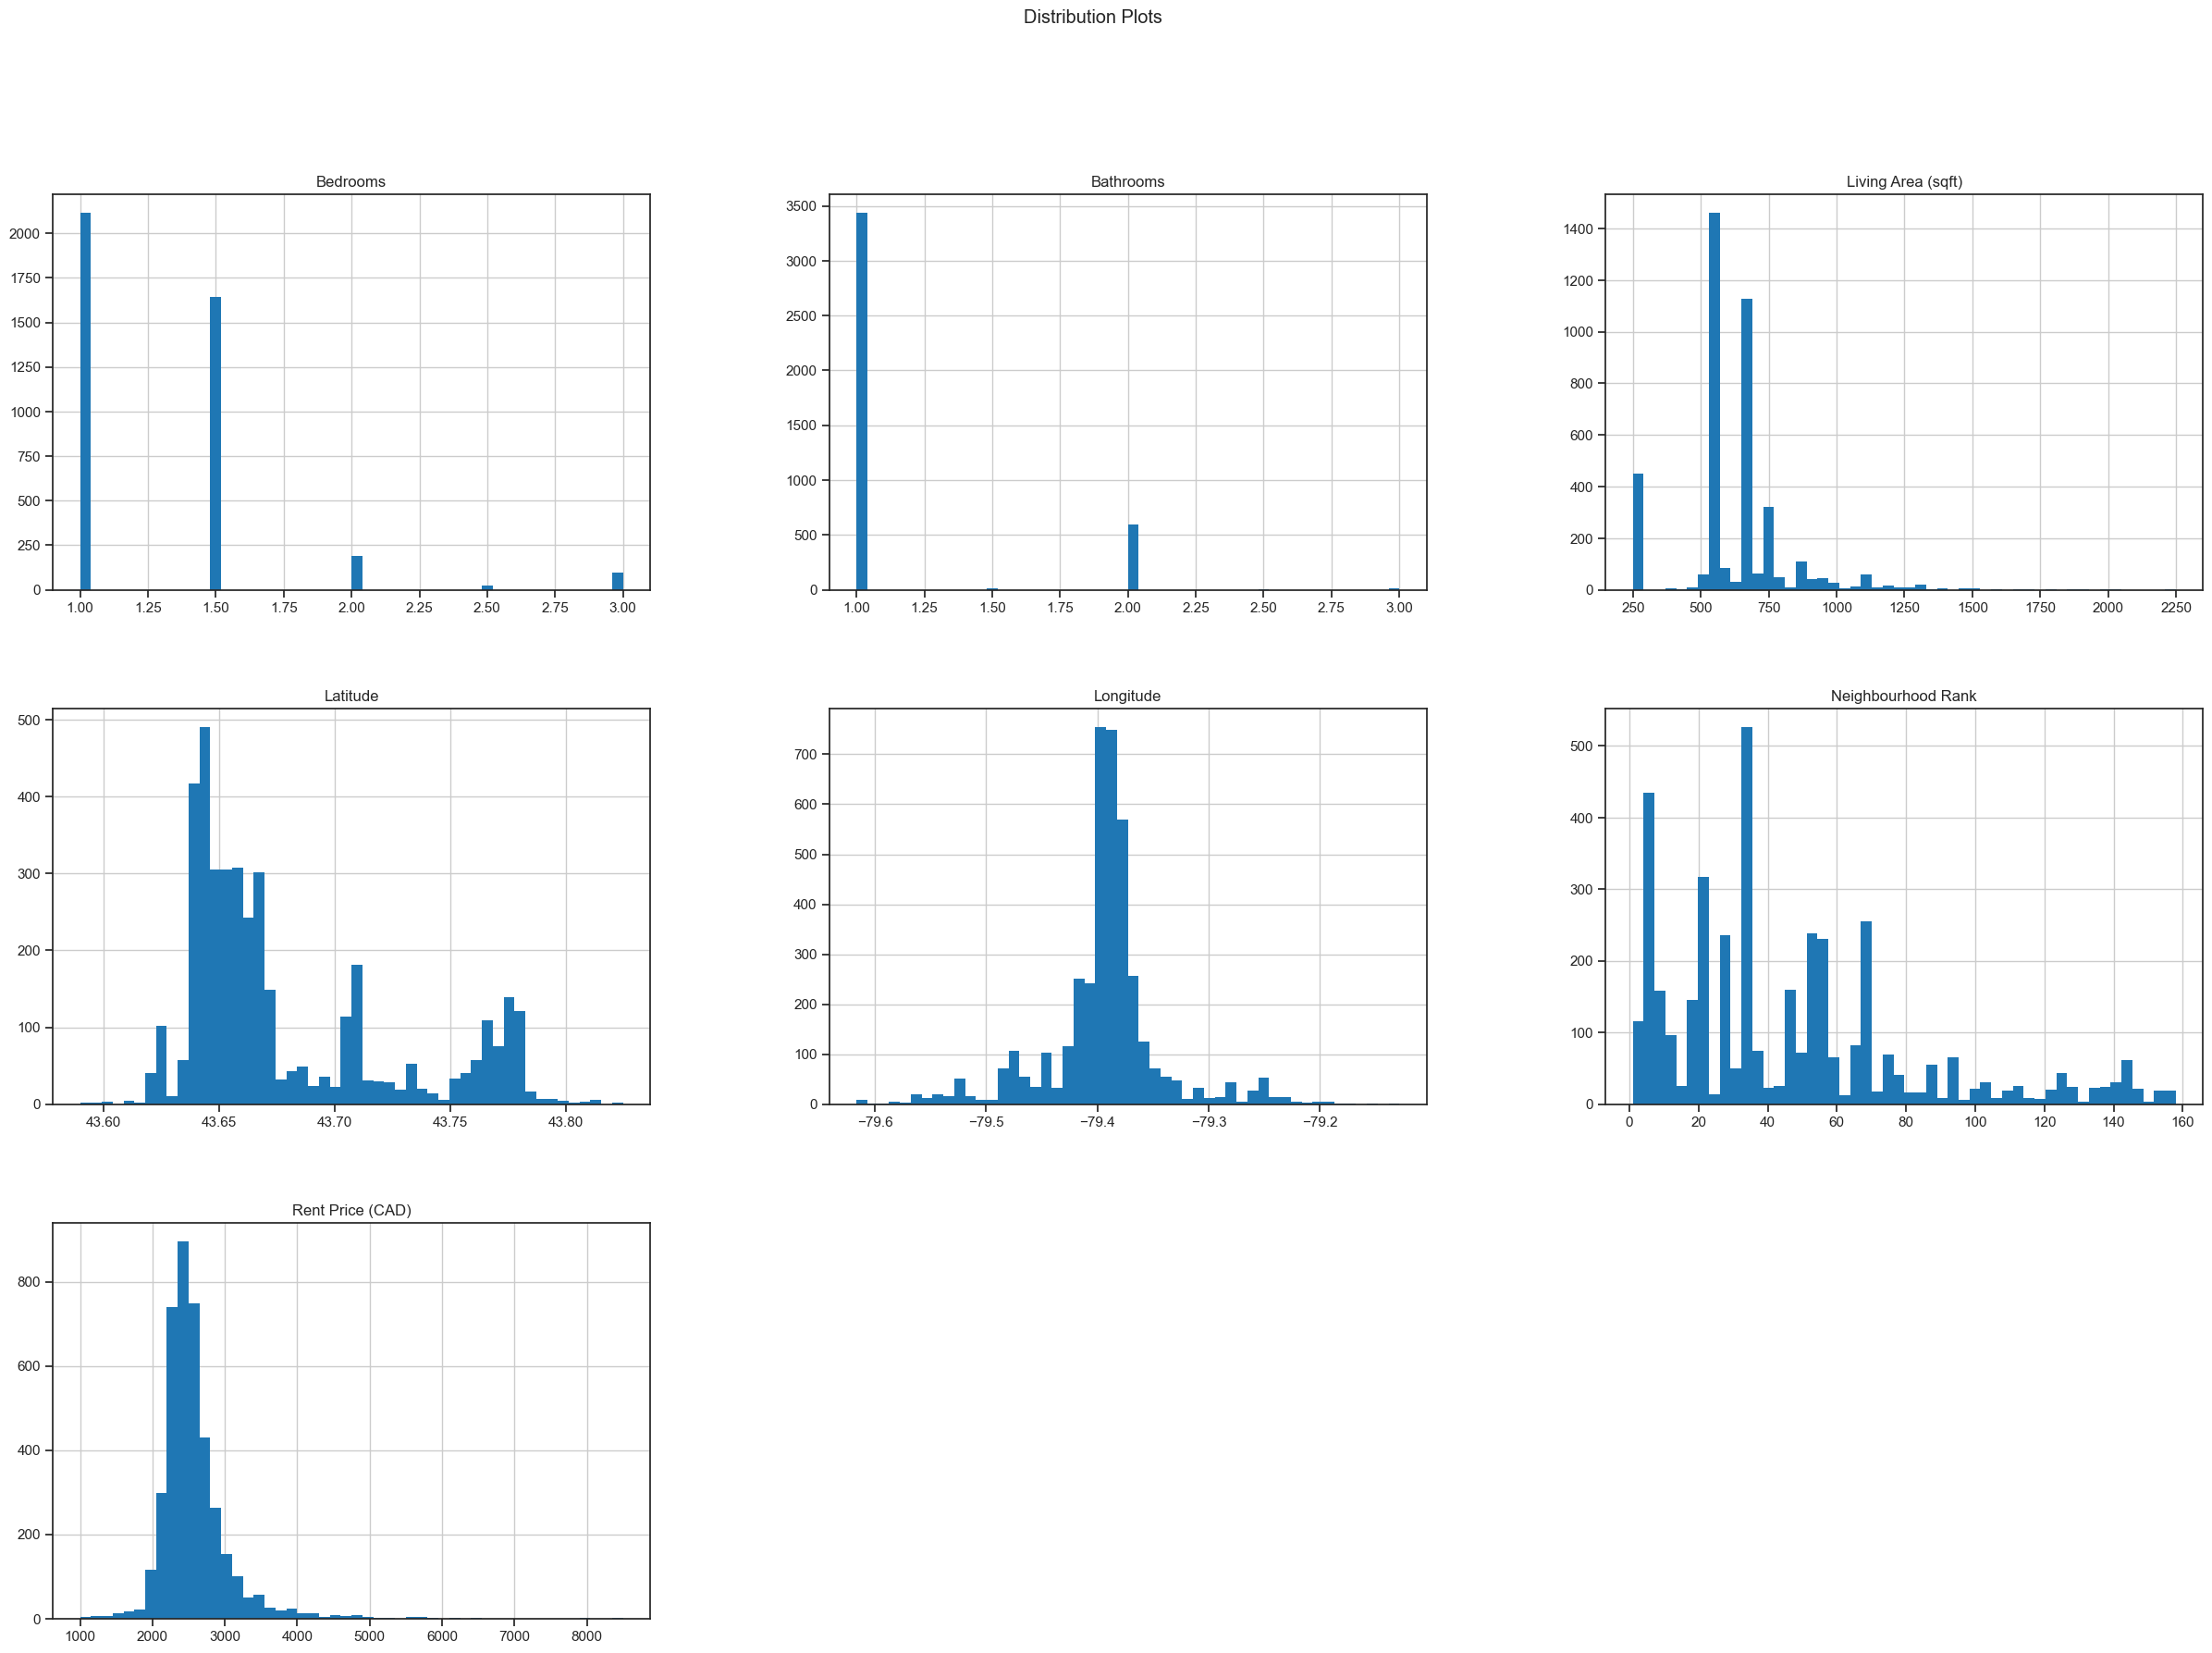

In [56]:
df.hist(bins=50, figsize=(30, 20))
plt.suptitle('Distribution Plots')
plt.show()

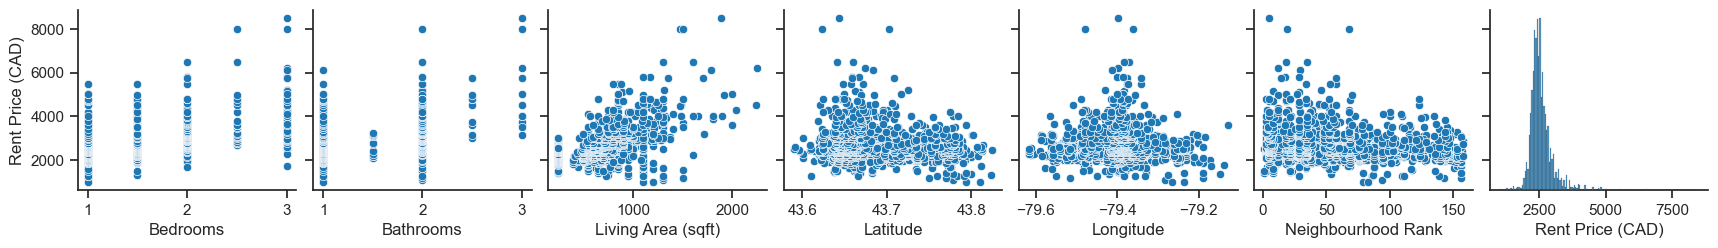

In [57]:
sns.pairplot(df, y_vars=['Rent Price (CAD)'], x_vars=df.select_dtypes(['number']).columns)

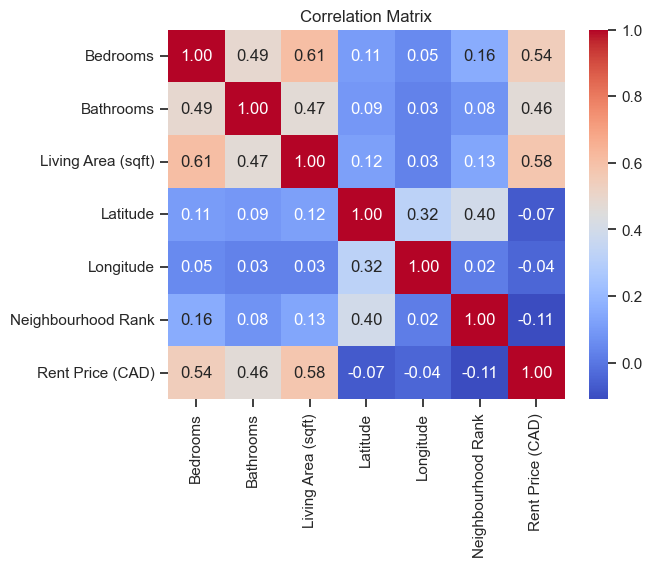

In [58]:
sns.heatmap(df.select_dtypes(['number']).corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

#### 2.2 Distribution of Rent Prices

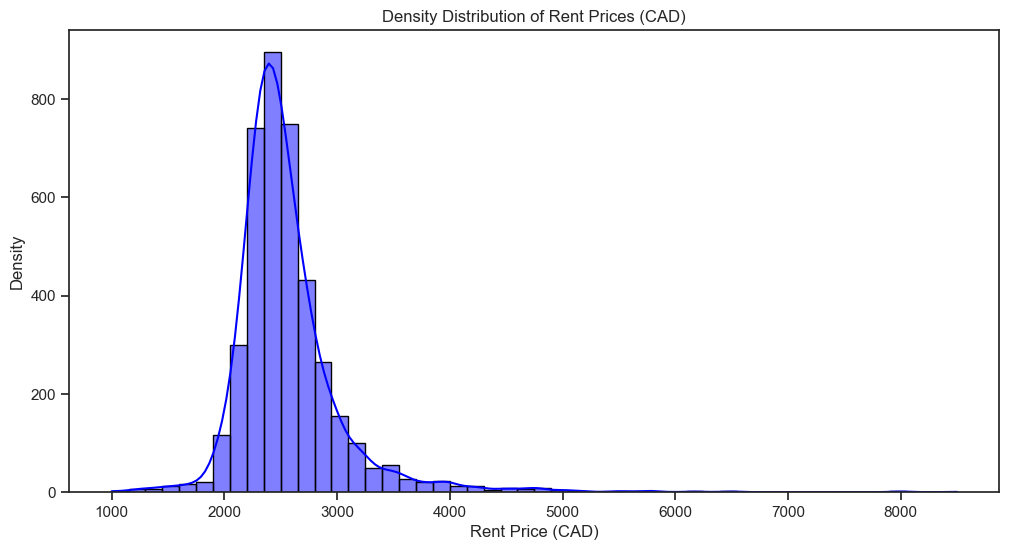

In [59]:
# Plot the distribution of rental prices
plt.figure(figsize=(12, 6))
sns.histplot(df['Rent Price (CAD)'], kde=True, color='blue', bins=50)
plt.xlabel('Rent Price (CAD)')
plt.ylabel('Density')
plt.title('Density Distribution of Rent Prices (CAD)')
plt.show()

AS seen above, the most common rent price is around 2400$ with normal distribution.

#### 2.3 Location Distribution of Rent Listings

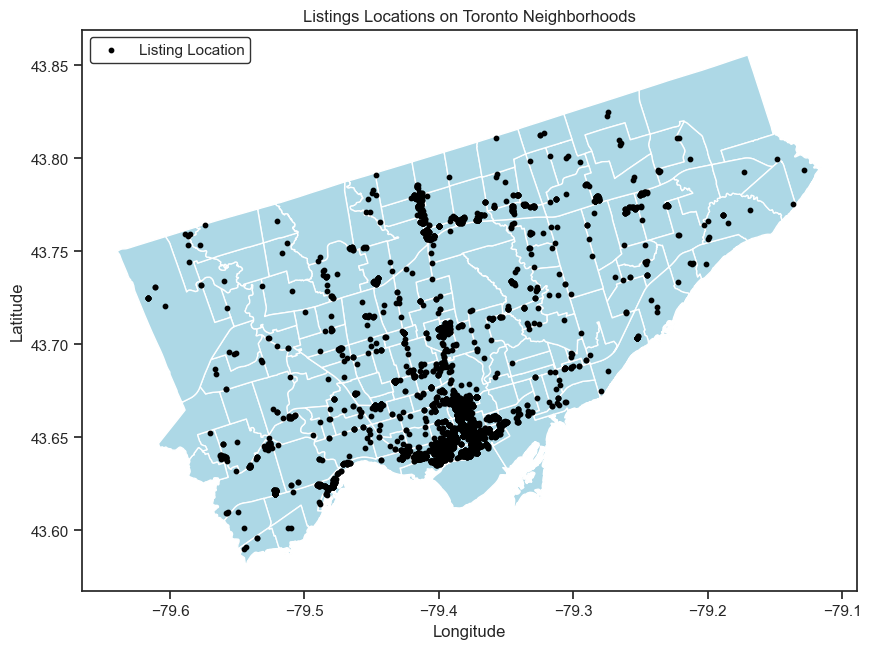

In [60]:
# Plot neighborhoods
fig, ax = plt.subplots(figsize=(10, 10))
neighbourhoods.plot(ax=ax, color='lightblue', edgecolor='white')

# Plot listings' locations
plt.scatter(df['Longitude'],df['Latitude'], color='black', s=10, label="Listing Location")

# Add labels and legend
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend(loc="upper left", frameon=True, edgecolor='black')
plt.title("Listings Locations on Toronto Neighborhoods")

plt.show()

Most of the listings are in downtown Toronto, so when we do the train/test split we will make sure the train, val, and test have the same porportion of listings from downtown.

#### 2.4 Relations between Features and Target (Rent Price).

**Living Area and Rent Price**

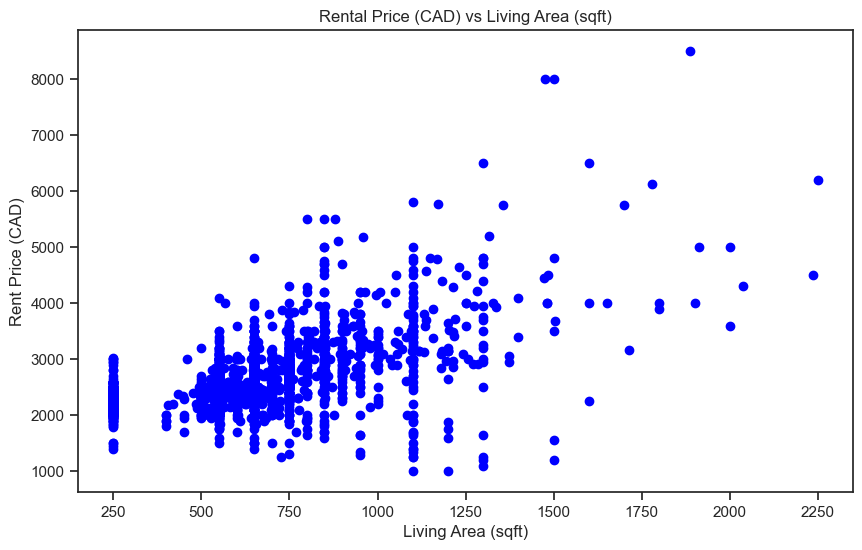

In [61]:
# Plot Rental price vs Living area
plt.figure(figsize=(10, 6))
plt.scatter(df['Living Area (sqft)'], df['Rent Price (CAD)'], color='blue')
plt.xlabel('Living Area (sqft)')
plt.ylabel('Rent Price (CAD)')
plt.title('Rental Price (CAD) vs Living Area (sqft)')
plt.show()

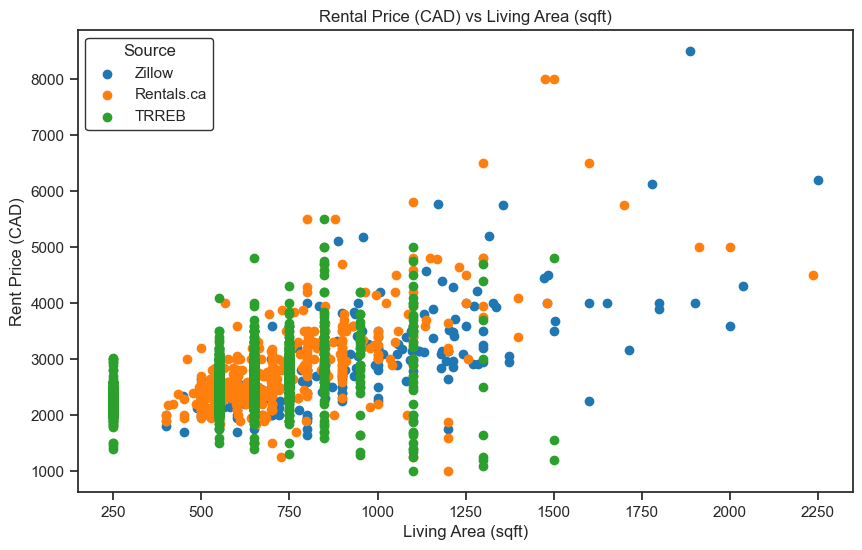

In [62]:
plt.figure(figsize=(10, 6))

# Define the desired order of sources
priority_source = "TRREB"  # Replace with the specific source you want on top
other_sources = [s for s in df['Source'].unique() if s != priority_source]

# Plot all other sources first
for source_value in other_sources:
    subset = df[df['Source'] == source_value]
    plt.scatter(subset['Living Area (sqft)'], subset['Rent Price (CAD)'], alpha=1, label=source_value)

# Plot the priority source last (on top)
priority_subset = df[df['Source'] == priority_source]
plt.scatter(priority_subset['Living Area (sqft)'], priority_subset['Rent Price (CAD)'], 
            alpha=1, label=priority_source)  # Optionally add edgecolor for emphasis

plt.xlabel('Living Area (sqft)')
plt.ylabel('Rent Price (CAD)')
plt.title('Rental Price (CAD) vs Living Area (sqft)')
plt.legend(title='Source', loc="upper left", frameon=True, edgecolor='black')
plt.show()

**Number of bedrooms and price**

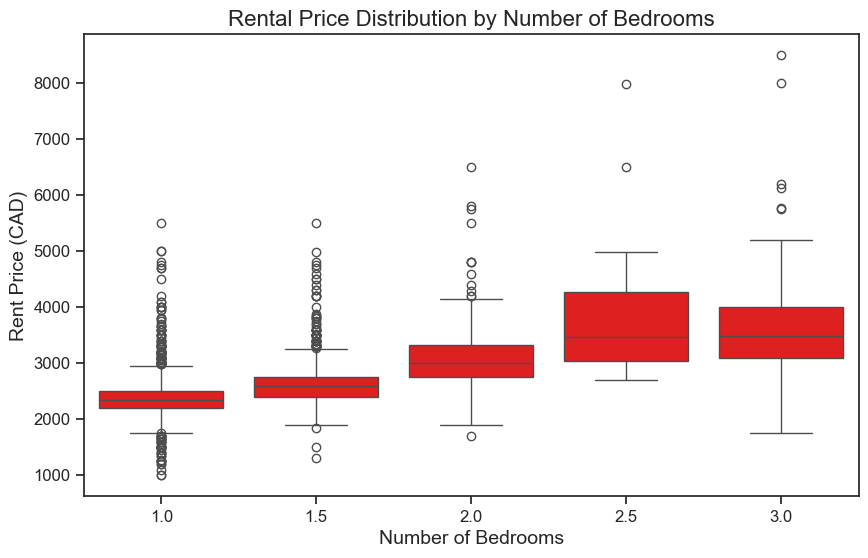

In [63]:
# Create the box plot
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='Bedrooms', y='Rent Price (CAD)', color='Red')

# Customize the plot
plt.title('Rental Price Distribution by Number of Bedrooms', fontsize=16)
plt.xlabel('Number of Bedrooms', fontsize=14)
plt.ylabel('Rent Price (CAD)', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Show the plot
plt.show()

**Number of Bathrooms and Rent Price**

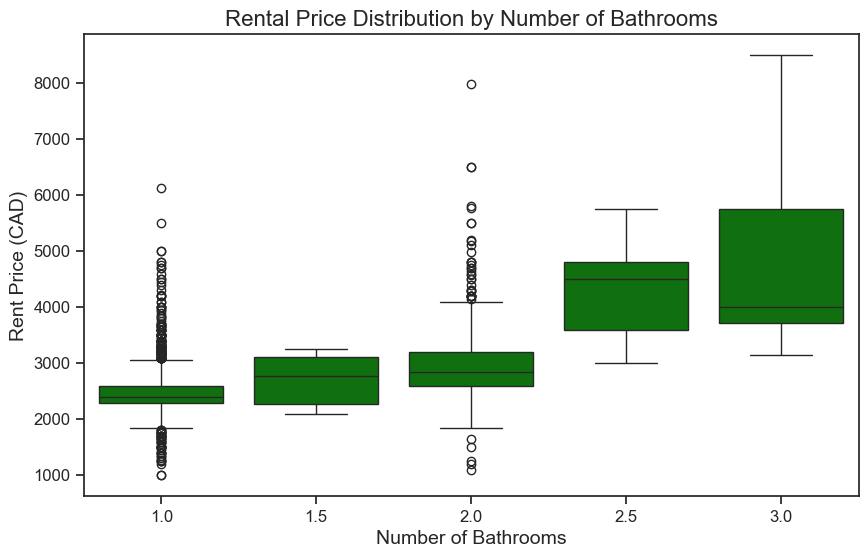

In [64]:
# Create the box plot for Bathrooms
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='Bathrooms', y='Rent Price (CAD)', color='Green')

# Customize the plot
plt.title('Rental Price Distribution by Number of Bathrooms', fontsize=16)
plt.xlabel('Number of Bathrooms', fontsize=14)
plt.ylabel('Rent Price (CAD)', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Show the plot
plt.show()

**Neighbourhood Rank and Rent Price**

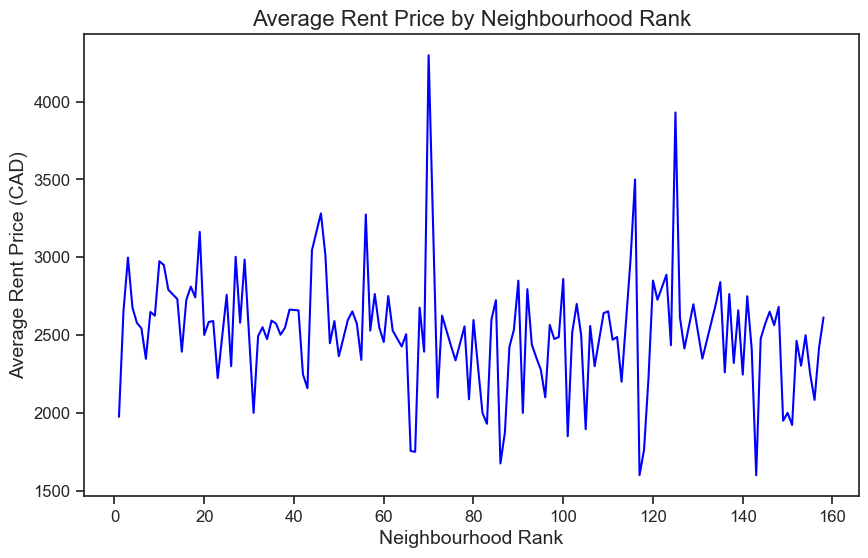

In [65]:
# Calculate the average rental price by neighborhood rank
avg_price_by_rank = df.groupby('Neighbourhood Rank')['Rent Price (CAD)'].mean().reset_index()

# Create the plot
plt.figure(figsize=(10, 6))
sns.lineplot(data=avg_price_by_rank, x='Neighbourhood Rank', y='Rent Price (CAD)', color='blue')

# Customize the plot
plt.title('Average Rent Price by Neighbourhood Rank', fontsize=16)
plt.xlabel('Neighbourhood Rank', fontsize=14)
plt.ylabel('Average Rent Price (CAD)', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Show the plot
plt.show()

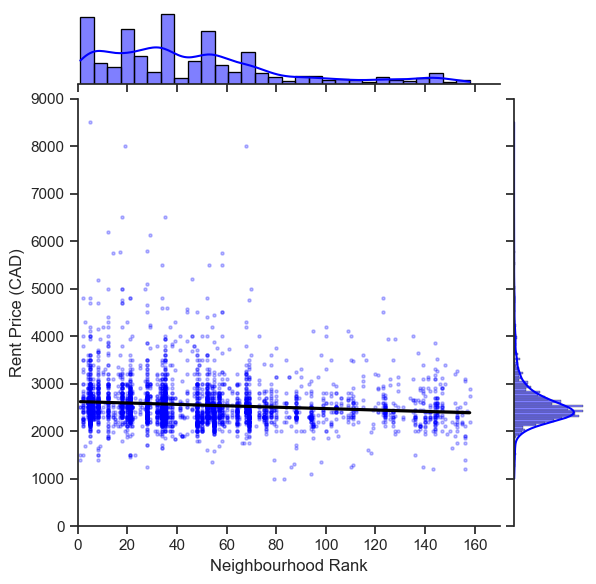

In [66]:
plot = sns.jointplot(data=df,
                     x='Neighbourhood Rank',
                     y='Rent Price (CAD)',
                     color='blue', kind='reg',
                     scatter_kws={'s': 5, 'alpha': 0.25}, line_kws={'color': 'black'})

plot.ax_joint.set_xlim([0,170])
plot.ax_joint.set_ylim([0,9000])

plt.show()

The trend is not always true but it seems that the expensive averages are in the higher ranked neighbourhoods.

### 3. Feature Engineering

In [67]:
df = pd.read_csv('Final Data.csv')

In [68]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4069 entries, 0 to 4068
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Listing ID          4069 non-null   object 
 1   Source              4069 non-null   object 
 2   Address             4069 non-null   object 
 3   Bedrooms            4069 non-null   float64
 4   Bathrooms           4069 non-null   float64
 5   Living Area (sqft)  4069 non-null   float64
 6   Latitude            4069 non-null   float64
 7   Longitude           4069 non-null   float64
 8   Neighbourhood       4069 non-null   object 
 9   Neighbourhood Rank  4069 non-null   float64
 10  Rent Price (CAD)    4069 non-null   float64
dtypes: float64(7), object(4)
memory usage: 349.8+ KB


#### 3.1 Split the data (train/val/test)

The train, val, and test should be divided evenly geographically. Therefore, the data is divided into clusters so that the resulting sets will have a proportional amount of data from each cluster.

Text(0.5, 1.0, 'Listings Locations on Toronto Neighborhoods with clustering')

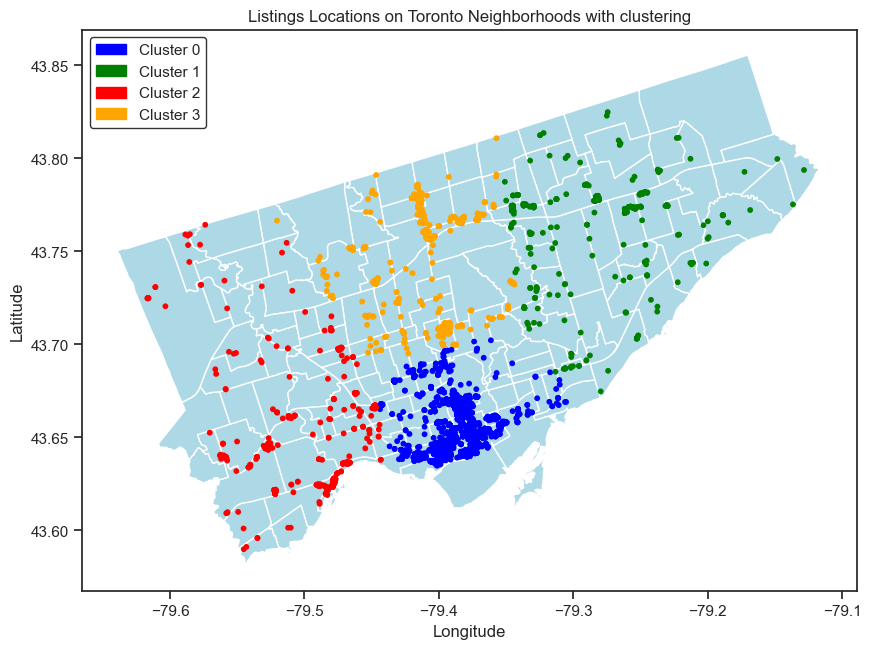

In [69]:
# Define the number of clusters (e.g., 4 clusters)
num_clusters = 4

# Perform clustering on latitude and longitude
kmeans = KMeans(n_clusters=num_clusters, random_state=4,  n_init=20)
df['Cluster'] = kmeans.fit_predict(df[['Latitude', 'Longitude']])

# Plot neighborhoods
fig, ax = plt.subplots(figsize=(10, 10))
neighbourhoods.plot(ax=ax, color='lightblue', edgecolor='white')

# Define colors for each cluster
colors = {0: 'blue', 1: 'green', 2: 'red', 3: 'orange'}

# Plot listings' locations
plt.scatter(df['Longitude'],df['Latitude'], c=df['Cluster'].map(colors), s=10)

# Add labels and legend
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend(handles=[mpatches.Patch(color=color, label=f'Cluster {i}') for i, color in colors.items()],
           loc="upper left", frameon=True, edgecolor='black')
plt.title("Listings Locations on Toronto Neighborhoods with clustering")

Dividing the dataset into: 70% Training - 15% Validation - 15% Test

In [70]:
train, temp = train_test_split(df, train_size=0.7, stratify=df['Cluster'], random_state=4)
val, test = train_test_split(temp, train_size=0.5, stratify=temp['Cluster'], random_state=4)

In [71]:
print(f"Train Size: {len(train)}, Validation Size: {len(val)}, Test Size: {len(test)}")

Train Size: 2848, Validation Size: 610, Test Size: 611


**Training set distribution**

Text(0.5, 1.0, 'Listings Locations on Toronto Neighborhoods with clustering (training set)')

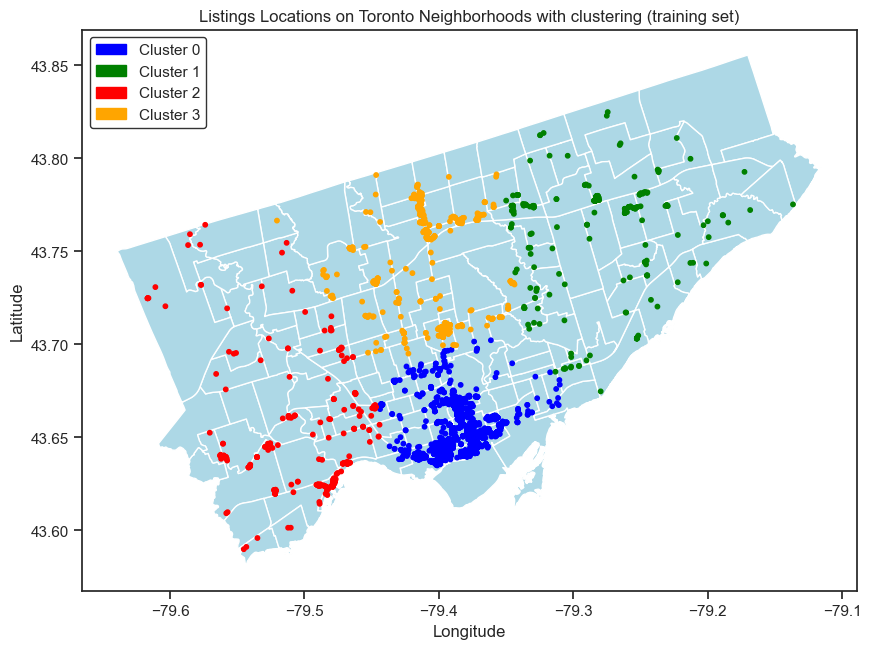

In [72]:
# Plot neighborhoods
fig, ax = plt.subplots(figsize=(10, 10))
neighbourhoods.plot(ax=ax, color='lightblue', edgecolor='white')

# Define colors for each cluster
colors = {0: 'blue', 1: 'green', 2: 'red', 3: 'orange'}

# Plot listings' locations
plt.scatter(train['Longitude'],train['Latitude'], c=train['Cluster'].map(colors), s=10)

# Add labels and legend
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend(handles=[mpatches.Patch(color=color, label=f'Cluster {i}') for i, color in colors.items()],
           loc="upper left", frameon=True, edgecolor='black')
plt.title("Listings Locations on Toronto Neighborhoods with clustering (training set)")

**Validation set distribution**

Text(0.5, 1.0, 'Listings Locations on Toronto Neighborhoods with clustering (validation set)')

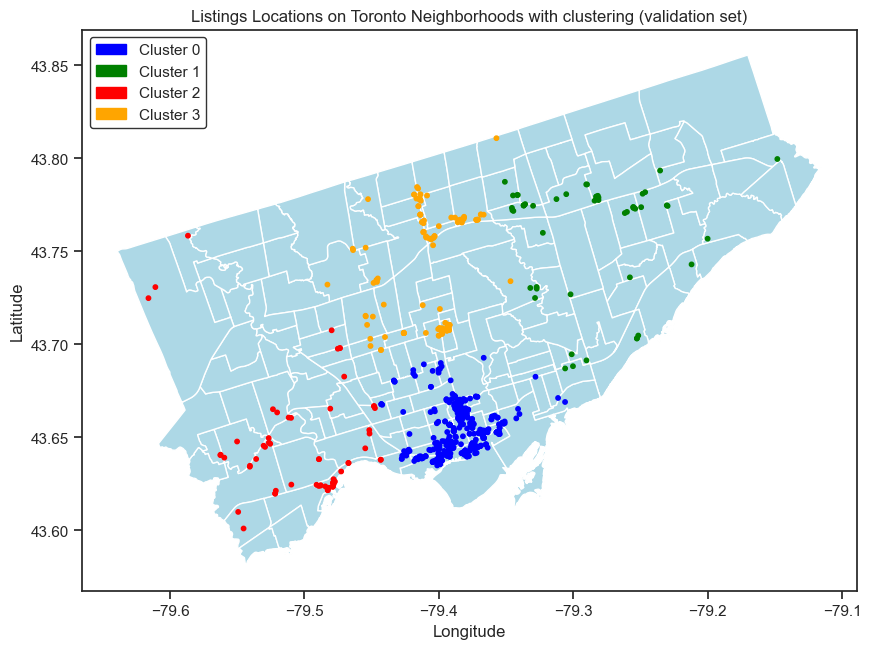

In [73]:
# Plot neighborhoods
fig, ax = plt.subplots(figsize=(10, 10))
neighbourhoods.plot(ax=ax, color='lightblue', edgecolor='white')

# Define colors for each cluster
colors = {0: 'blue', 1: 'green', 2: 'red', 3: 'orange'}

# Plot listings' locations
plt.scatter(val['Longitude'],val['Latitude'], c=val['Cluster'].map(colors), s=10)

# Add labels and legend
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend(handles=[mpatches.Patch(color=color, label=f'Cluster {i}') for i, color in colors.items()],
           loc="upper left", frameon=True, edgecolor='black')
plt.title("Listings Locations on Toronto Neighborhoods with clustering (validation set)")

**Test set distribution**

Text(0.5, 1.0, 'Listings Locations on Toronto Neighborhoods with clustering (test set)')

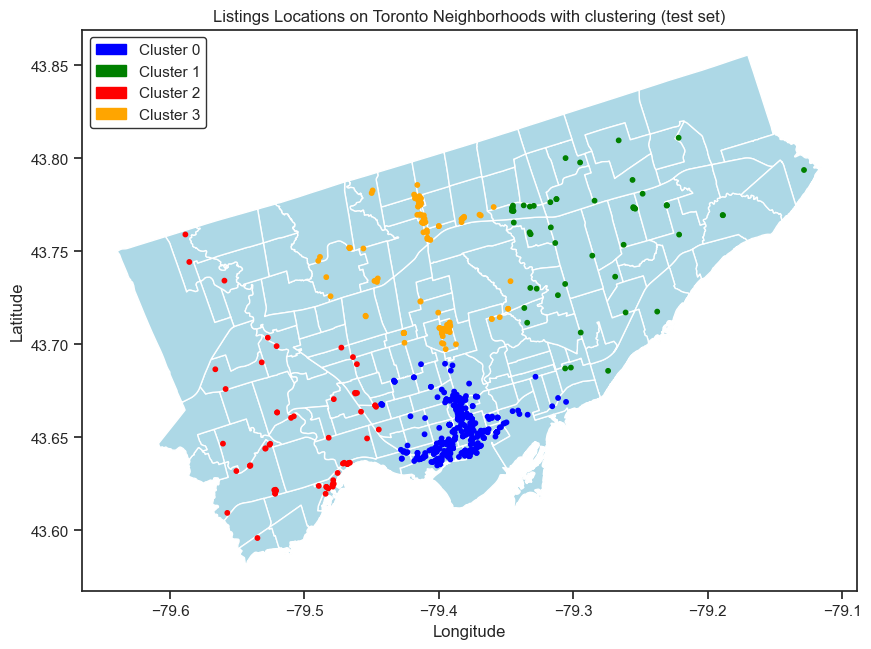

In [74]:
# Plot neighborhoods
fig, ax = plt.subplots(figsize=(10, 10))
neighbourhoods.plot(ax=ax, color='lightblue', edgecolor='white')

# Define colors for each cluster
colors = {0: 'blue', 1: 'green', 2: 'red', 3: 'orange'}

# Plot listings' locations
plt.scatter(test['Longitude'],test['Latitude'], c=test['Cluster'].map(colors), s=10)

# Add labels and legend
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend(handles=[mpatches.Patch(color=color, label=f'Cluster {i}') for i, color in colors.items()],
           loc="upper left", frameon=True, edgecolor='black')
plt.title("Listings Locations on Toronto Neighborhoods with clustering (test set)")

#### 3.2 Functions

In this section, several functions are created. Those functions will be used in the modeling.

In [75]:
def create_features(df):
    """
    Creates various columns (features) in the DataFrame.

    Parameters:
        df (DataFrame): The original DataFrame.

    Returns:
        df_copy (DataFrame): A copy of the original DataFrame with all new columns (features).
    """
    df_copy = df.copy()

    # Extract Longitude and Latitude
    location_data = df_copy[["Longitude", "Latitude"]]

    # Scale Longitude and Latitude before PCA
    scaler = StandardScaler()
    location_scaled = scaler.fit_transform(location_data)

    # Perform PCA and add PC1 to the dataset
    pca = PCA(n_components=1)
    df_copy['PC1'] = pca.fit_transform(location_scaled)
    
    return df_copy

In [76]:
def preprocess_data(df):

    """
    Removes specified redundant columns from the DataFrame and scale specified columns.

    Parameters:
        df (DataFrame): The Original DataFrame.

    Returns:
        df_copy (DataFrame): A copy of the original DataFrame after processing.

    """
    df_copy = df.copy()

    # Drop unnecessary columns
    columns_to_drop = ['Address', 'Source', 'Latitude', 'Longitude', 'Neighbourhood', 'Cluster']
    df_copy = df_copy.drop(columns=columns_to_drop)
    
    # Identify numeric columns that need scaling
    columns_to_scale = ['Bedrooms', 'Bathrooms', 'Living Area (sqft)','Neighbourhood Rank', 'PC1']
    
    # Fit the scaler on the training data
    scaler = StandardScaler()
    df_copy[columns_to_scale] = scaler.fit_transform(df_copy[columns_to_scale])
    
    return df_copy

In [77]:
def select_features(df, target=None, features=None):

    """
    Select specified columns from the DataFrames.

    Parameters:
        df (DataFrame): The Original DataFrame.

    Returns:
        df_copy (DataFrame): A copy of the original DataFrame with specified columns only.

    """
    df_copy = df.copy()
    
    if target:
        return df_copy[target + features]
    else:
        return df_copy[features]

### 4. Modeling

#### 4.1 Simple Model (Always Predicts the Mean)

In [78]:
def simple_model(train,val):

    """
    Train and fit a simple model on the training dataset and return R² and RMSE of the validation dataset.

    Parameters:
        train (DataFrame): The training DataFrame.
        val (DataFrame): The validation DataFrame.

    Returns:
         (float): R² score of the validation dataset.
    """

    # Calculate the mean rent from the training set
    mean_rent = train['Rent Price (CAD)'].mean()

    y_train = train['Rent Price (CAD)']
    y_val = val['Rent Price (CAD)']

    y_train_pred = np.full_like(train['Rent Price (CAD)'], fill_value=mean_rent)
    y_val_pred = np.full_like(val['Rent Price (CAD)'], fill_value=mean_rent)

    # Evaluate the model on the training set
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    train_r2 = r2_score(y_train, y_train_pred)

    # Evaluate the model on the validation set
    val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
    val_r2 = r2_score(y_val, y_val_pred)

    # Print results
    print("Baseline Model Performance:")
    print(f"Training RMSE: {train_rmse:.2f}, Training R²: {train_r2:.2f}")
    print(f"Validation RMSE: {val_rmse:.2f}, Validation R²: {val_r2:.2f}")

    return round(val_r2,2)

In [79]:
simple_model(train,val)

Baseline Model Performance:
Training RMSE: 503.38, Training R²: 0.00
Validation RMSE: 435.57, Validation R²: -0.01


-0.01

#### 4.2 Linear Model

In [80]:
def linear_model(train,val,target,features):

    """
    Train and fit the linear model on the training dataset and return R² and RMSE of the validation dataset.

    Parameters:
        train (DataFrame): The training DataFrame.
        val (DataFrame): The validation DataFrame.
        target (str): The target column name.
        features (list): The feature column names.

    Returns:
         (float): R² score of the validation dataset.
    """

    train = create_features(train)      # Avoiding data leakage
    val = create_features(val)

    train = preprocess_data(train)      # Avoiding data leakage
    val = preprocess_data(val)

    train = select_features(train,target,features)
    val = select_features(val,target,features)

    X_train = train.drop(target, axis = 1)
    y_train = train.loc[:, target]

    X_val = val.drop(target, axis = 1)
    y_val = val.loc[:, target]

    model = LinearRegression(fit_intercept=True)
    model.fit(X_train, y_train)

    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)

    # Evaluate the model on the training set
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    train_r2 = r2_score(y_train, y_train_pred)

    # Evaluate the model on the validation set
    val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
    val_r2 = r2_score(y_val, y_val_pred)

    # Print results
    print("Linear Regression Model Performance:")
    print(f"Training RMSE: {train_rmse:.2f}, Training R²: {train_r2:.2f}")
    print(f"Validation RMSE: {val_rmse:.2f}, Validation R²: {val_r2:.2f}")

    return round(val_r2,2)

In [81]:
features = ['Bedrooms', 'Bathrooms', 'Living Area (sqft)', 'Neighbourhood Rank', 'PC1']
target = ['Rent Price (CAD)']
linear_model(train,val,target,features)

Linear Regression Model Performance:
Training RMSE: 364.12, Training R²: 0.48
Validation RMSE: 347.40, Validation R²: 0.36


0.36

#### 4.3 Random Forest Model

In [82]:
def rf_model(train,val, target, features, param_distributions=None, n_iter=10):
    """
    Train and optimize the Random Forest model using RandomizedSearchCV.

    Parameters:
        train (DataFrame): The training DataFrame.
        val (DataFrame): The validation DataFrame.
        target (str): The target column name.
        features (list): The feature column names.
        param_distributions (dict): The hyperparameter grid for randomized search.
        n_iter (int): Number of parameter combinations to try.

    Returns:
        dict: Best model and best hyperparameters.
    """
    if param_distributions is None:
        param_distributions = {
            'n_estimators': [50, 100, 200],
            'max_depth': [5, 10, 20, 30],
            'min_samples_split': [2, 5, 20, 40],
            'min_samples_leaf': [1, 2, 5]
            }

    train = create_features(train)      # Avoiding data leakage
    val = create_features(val)

    train = preprocess_data(train)      # Avoiding data leakage
    val = preprocess_data(val)

    train = select_features(train, target, features)
    val = select_features(val, target, features)

    X_train = train.drop(target, axis = 1)
    y_train = train.loc[:, target]

    X_val = val.drop(target, axis = 1)
    y_val = val.loc[:, target]

    # Initialize Random Forest and RandomizedSearchCV
    model = RandomForestRegressor(random_state=4)
    random_search = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_distributions,
        n_iter=n_iter,
        scoring='r2',
        cv=KFold(n_splits=3),
        random_state=4
    )
    
    # Fit the RandomizedSearchCV
    random_search.fit(X_train, y_train)

    # Get the best model, parameters, and cross-validation score
    best_model = random_search.best_estimator_
    best_params = random_search.best_params_
    best_cv_r2 = random_search.best_score_

    # Validate on the hold-out validation set
    y_val_pred = best_model.predict(X_val)
    val_r2 = r2_score(y_val, y_val_pred)
    val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))

    print(f"Best Parameters: {best_params}")
    print(f"Best CV R² Score: {best_cv_r2:.2f}")
    print(f"Validation R² Score: {val_r2:.2f}")
    print(f"Validation RMSE: {val_rmse:.2f}")

    # Extracting features importance
    feature_importances = best_model.feature_importances_
    feature_names = X_train.columns
    importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
    importance_df = importance_df.sort_values(by='Importance', ascending=False)

    # Plot features importance
    plt.barh(importance_df['Feature'], importance_df['Importance'])
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.title('Feature Importance')
    plt.show()

    return  best_model, best_params

Best Parameters: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 20}
Best CV R² Score: 0.53
Validation R² Score: 0.41
Validation RMSE: 332.64


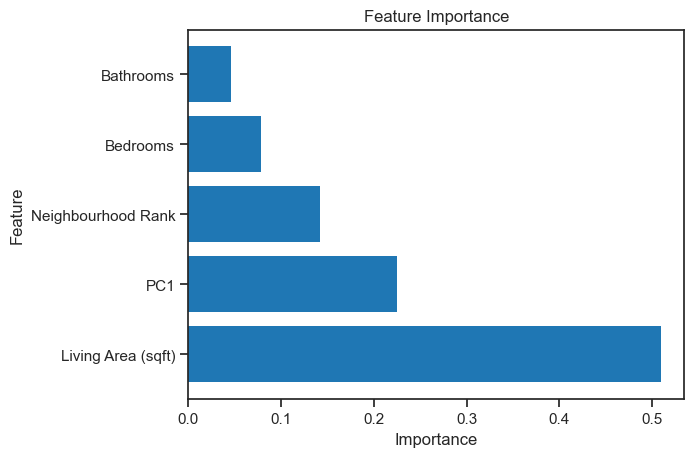

In [83]:
features = ['Bedrooms', 'Bathrooms', 'Living Area (sqft)', 'Neighbourhood Rank', 'PC1']
target = ['Rent Price (CAD)']
model, hyperparameter = rf_model(train,val,target,features)

#### 4.4 Final Model

The follwoing function is for the final model on the test dataset.

In [84]:
def final_model(train, test, target, features, param_distributions, n_iter=10):

    """
    Train and fit the final model on the entire training dataset.

    Parameters:
        train (DataFrame): The entire training (train+val) DataFrame.
        test (DataFrame): The test DataFrame.
        target (str): The target column name.
        features (list): The feature column names.
        param_distributions (dict): The optimized hyperparameter grid.
        n_iter (int): Number of parameter combinations to try.

    Returns:
        best_model: Final model.
    """

    train = create_features(train)      # Avoiding data leakage
    test = create_features(test)

    train = preprocess_data(train)      # Avoiding data leakage
    test = preprocess_data(test)

    train = select_features(train, target, features)
    test = select_features(test, target, features)

    X_train = train.drop(target, axis = 1)
    y_train = train.loc[:, target]

    X_test = test.drop(target, axis = 1)
    y_test = test.loc[:, target]

    model = RandomForestRegressor(random_state=44)
    random_search = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_distributions,
        n_iter=n_iter,
        scoring='r2',
        cv=KFold(n_splits=3),
        random_state=4
    )
    
    random_search.fit(X_train, y_train)

    best_model = random_search.best_estimator_

    y_train_pred = best_model.predict(X_train)
    y_test_pred = best_model.predict(X_test)

    # Evaluate the model on the entire training set
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    train_r2 = r2_score(y_train, y_train_pred)

    # Evaluate the model on the validation set
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    test_r2 = r2_score(y_test, y_test_pred)

    # Print results
    print("Final Model Performance:")
    print(f"Training RMSE: {train_rmse:.2f}, Training R²: {train_r2:.2f}")
    print(f"Test RMSE: {test_rmse:.2f}, Test R²: {test_r2:.2f}")

    return  best_model

### 5. Prediction on the test dataset

DO NOT RUN NOW. RUN ONLY AFTER SELECTING THE MODEL.

In [87]:
features = ['Bedrooms', 'Bathrooms', 'Living Area (sqft)', 'Neighbourhood Rank', 'PC1']
target = ['Rent Price (CAD)']
param_distributions = {
            'n_estimators': [200],
            'max_depth': [20],
            'min_samples_split': [5],
            'min_samples_leaf': [1]}

# Combine train and val into one dataframe
entire_train = pd.concat([train, val], ignore_index=True)
                                 
best_model = final_model(entire_train, test, target, features, param_distributions)

Final Model Performance:
Training RMSE: 177.54, Training R²: 0.87
Test RMSE: 307.44, Test R²: 0.60
